# 📈 Week 5 Trading Strategy: Portfolio Optimization

---

## 🎯 Strategy Overview

**Building on Weeks 1-4 + Adding Week 5 Concepts:**
- Foundation concepts (returns, volatility, correlation)
- Statistical analysis (distributions, hypothesis testing)
- Time series analysis (stationarity, GARCH)
- ML foundations (regression, regularization)
- **NEW:** Modern Portfolio Theory (MPT)
- **NEW:** Efficient Frontier
- **NEW:** Mean-Variance Optimization
- **NEW:** Risk Parity & Maximum Sharpe

**Strategy Logic:**
1. Analyze individual stocks with ML
2. Construct optimal portfolio using MPT
3. Compare different optimization methods
4. Dynamic rebalancing recommendations

---

In [1]:
# ============================================================
# CONFIGURATION
# ============================================================
# Tech stocks: AAPL, GOOGL, MSFT | Finance stocks: GS, JPM
TICKERS = ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 2
RISK_FREE_RATE = 0.05  # Annual

print("=" * 60)
print("📊 WEEK 5 TRADING STRATEGY: PORTFOLIO OPTIMIZATION")
print("=" * 60)
print(f"\n🎯 Portfolio Assets: {TICKERS}")
print(f"📅 Risk-Free Rate: {RISK_FREE_RATE:.2%}")

📊 WEEK 5 TRADING STRATEGY: PORTFOLIO OPTIMIZATION

🎯 Portfolio Assets: ['AAPL', 'GOOGL', 'MSFT', 'GS', 'JPM']
📅 Risk-Free Rate: 5.00%


In [2]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 504 trading days


---

## 📊 Section 1: Portfolio Statistics (Week 5 Concept)

**Computing:**
- Expected returns (annualized)
- Volatility (annualized)
- Covariance matrix
- Correlation matrix

**These are inputs to portfolio optimization!**

In [3]:
# ============================================================
# PORTFOLIO STATISTICS
# ============================================================

# Annualized statistics
annual_returns = returns[TICKERS].mean() * 252
annual_vol = returns[TICKERS].std() * np.sqrt(252)
cov_matrix = returns[TICKERS].cov() * 252
corr_matrix = returns[TICKERS].corr()

print("📊 ANNUALIZED STATISTICS")
print("=" * 70)
print("\n📈 Expected Returns:")
for ticker in TICKERS:
    print(f"   {ticker}: {annual_returns[ticker]:>8.2%}")

print("\n📉 Volatility:")
for ticker in TICKERS:
    print(f"   {ticker}: {annual_vol[ticker]:>8.2%}")

print("\n📊 Sharpe Ratios (Individual Assets):")
sharpe = (annual_returns - RISK_FREE_RATE) / annual_vol
for ticker in TICKERS:
    print(f"   {ticker}: {sharpe[ticker]:>8.2f}")

📊 ANNUALIZED STATISTICS

📈 Expected Returns:
   AAPL:   16.64%
   GOOGL:   45.50%
   MSFT:   11.33%
   GS:   49.91%
   JPM:   33.22%

📉 Volatility:
   AAPL:   27.82%
   GOOGL:   30.24%
   MSFT:   22.43%
   GS:   29.11%
   JPM:   24.59%

📊 Sharpe Ratios (Individual Assets):
   AAPL:     0.42
   GOOGL:     1.34
   MSFT:     0.28
   GS:     1.54
   JPM:     1.15


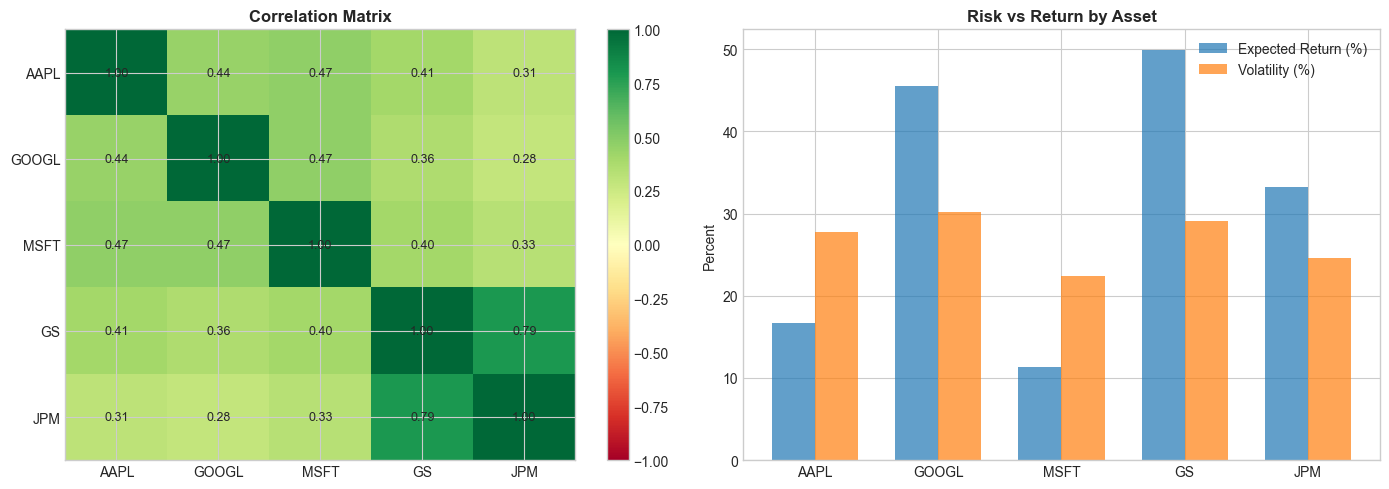

In [4]:
# ============================================================
# CORRELATION & COVARIANCE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax1 = axes[0]
im1 = ax1.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax1.set_xticks(range(len(TICKERS)))
ax1.set_yticks(range(len(TICKERS)))
ax1.set_xticklabels(TICKERS)
ax1.set_yticklabels(TICKERS)
ax1.set_title('Correlation Matrix', fontsize=12, fontweight='bold')
for i in range(len(TICKERS)):
    for j in range(len(TICKERS)):
        ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=ax1)

# Individual metrics
ax2 = axes[1]
x = np.arange(len(TICKERS))
width = 0.35
ax2.bar(x - width/2, annual_returns * 100, width, label='Expected Return (%)', alpha=0.7)
ax2.bar(x + width/2, annual_vol * 100, width, label='Volatility (%)', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.set_title('Risk vs Return by Asset', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percent')
ax2.legend()

plt.tight_layout()
plt.show()

---

## 📊 Section 2: Efficient Frontier (Week 5 Concept)

**Modern Portfolio Theory (MPT):**
- For any target return, find minimum variance portfolio
- Plot the frontier of optimal portfolios
- Find the Maximum Sharpe Ratio portfolio

**Key Insight:** Diversification reduces risk!

In [5]:
# ============================================================
# EFFICIENT FRONTIER
# ============================================================

def portfolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_sharpe(weights, returns, cov_matrix, rf_rate):
    ret = portfolio_return(weights, returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - rf_rate) / vol

def neg_sharpe(weights, returns, cov_matrix, rf_rate):
    return -portfolio_sharpe(weights, returns, cov_matrix, rf_rate)

# Constraints and bounds
n_assets = len(TICKERS)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(n_assets))  # Long only

# Generate efficient frontier
frontier_returns = []
frontier_volatilities = []
frontier_weights = []

target_returns = np.linspace(annual_returns.min(), annual_returns.max(), 50)

for target in target_returns:
    cons = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x, r=target: portfolio_return(x, annual_returns) - r}
    ]
    
    result = minimize(
        portfolio_volatility, 
        np.array([1/n_assets] * n_assets),
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    
    if result.success:
        frontier_returns.append(target)
        frontier_volatilities.append(result.fun)
        frontier_weights.append(result.x)

print(f"✅ Generated {len(frontier_returns)} efficient frontier portfolios")

✅ Generated 50 efficient frontier portfolios


In [6]:
# ============================================================
# OPTIMAL PORTFOLIOS
# ============================================================

# 1. Maximum Sharpe Ratio Portfolio
initial_weights = np.array([1/n_assets] * n_assets)
result_sharpe = minimize(
    neg_sharpe, 
    initial_weights,
    args=(annual_returns, cov_matrix, RISK_FREE_RATE),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
max_sharpe_weights = result_sharpe.x
max_sharpe_ret = portfolio_return(max_sharpe_weights, annual_returns)
max_sharpe_vol = portfolio_volatility(max_sharpe_weights, cov_matrix)

# 2. Minimum Variance Portfolio
result_minvar = minimize(
    portfolio_volatility, 
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
min_var_weights = result_minvar.x
min_var_ret = portfolio_return(min_var_weights, annual_returns)
min_var_vol = portfolio_volatility(min_var_weights, cov_matrix)

# 3. Equal Weight Portfolio
equal_weights = np.array([1/n_assets] * n_assets)
equal_ret = portfolio_return(equal_weights, annual_returns)
equal_vol = portfolio_volatility(equal_weights, cov_matrix)

# 4. Risk Parity Portfolio (approximate)
inv_vol = 1 / annual_vol
risk_parity_weights = inv_vol / inv_vol.sum()
rp_ret = portfolio_return(risk_parity_weights.values, annual_returns)
rp_vol = portfolio_volatility(risk_parity_weights.values, cov_matrix)

print("📊 OPTIMAL PORTFOLIO COMPARISON")
print("=" * 75)
print(f"\n{'Portfolio':<25} {'Return':>12} {'Volatility':>12} {'Sharpe':>12}")
print("-" * 75)
print(f"{'Maximum Sharpe':<25} {max_sharpe_ret:>11.2%} {max_sharpe_vol:>11.2%} {(max_sharpe_ret-RISK_FREE_RATE)/max_sharpe_vol:>11.2f}")
print(f"{'Minimum Variance':<25} {min_var_ret:>11.2%} {min_var_vol:>11.2%} {(min_var_ret-RISK_FREE_RATE)/min_var_vol:>11.2f}")
print(f"{'Equal Weight':<25} {equal_ret:>11.2%} {equal_vol:>11.2%} {(equal_ret-RISK_FREE_RATE)/equal_vol:>11.2f}")
print(f"{'Risk Parity':<25} {rp_ret:>11.2%} {rp_vol:>11.2%} {(rp_ret-RISK_FREE_RATE)/rp_vol:>11.2f}")

📊 OPTIMAL PORTFOLIO COMPARISON

Portfolio                       Return   Volatility       Sharpe
---------------------------------------------------------------------------
Maximum Sharpe                 48.08%      24.55%        1.75
Minimum Variance               23.00%      18.44%        0.98
Equal Weight                   31.32%      19.77%        1.33
Risk Parity                    30.08%      19.50%        1.29


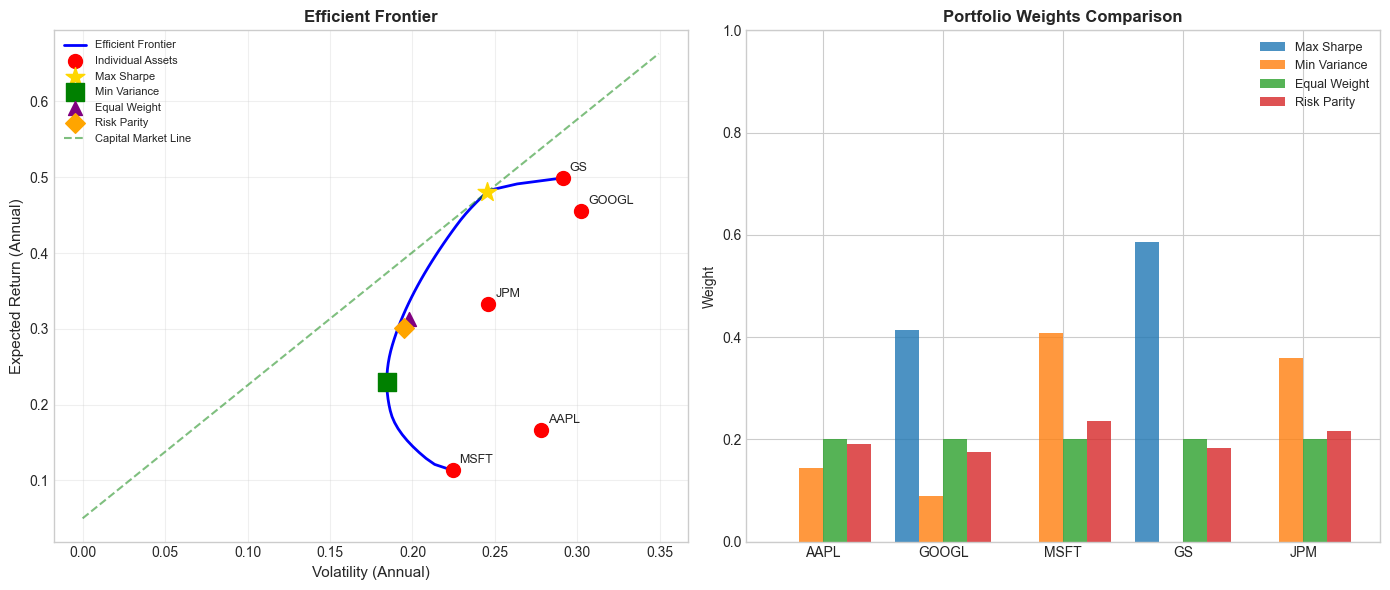

In [7]:
# ============================================================
# EFFICIENT FRONTIER VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Efficient Frontier with Optimal Portfolios
ax1 = axes[0]
ax1.plot(frontier_volatilities, frontier_returns, 'b-', linewidth=2, label='Efficient Frontier')

# Plot individual assets
ax1.scatter(annual_vol, annual_returns, c='red', s=100, label='Individual Assets', zorder=5)
for i, ticker in enumerate(TICKERS):
    ax1.annotate(ticker, (annual_vol[ticker], annual_returns[ticker]), xytext=(5, 5), 
                textcoords='offset points', fontsize=9)

# Plot optimal portfolios
ax1.scatter(max_sharpe_vol, max_sharpe_ret, c='gold', s=200, marker='*', label='Max Sharpe', zorder=10)
ax1.scatter(min_var_vol, min_var_ret, c='green', s=150, marker='s', label='Min Variance', zorder=10)
ax1.scatter(equal_vol, equal_ret, c='purple', s=100, marker='^', label='Equal Weight', zorder=10)
ax1.scatter(rp_vol, rp_ret, c='orange', s=100, marker='D', label='Risk Parity', zorder=10)

# Capital Market Line
cml_x = np.linspace(0, max(frontier_volatilities) * 1.2, 100)
cml_y = RISK_FREE_RATE + ((max_sharpe_ret - RISK_FREE_RATE) / max_sharpe_vol) * cml_x
ax1.plot(cml_x, cml_y, 'g--', alpha=0.5, label='Capital Market Line')

ax1.set_xlabel('Volatility (Annual)', fontsize=11)
ax1.set_ylabel('Expected Return (Annual)', fontsize=11)
ax1.set_title('Efficient Frontier', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Portfolio Weights Comparison
ax2 = axes[1]
x = np.arange(len(TICKERS))
width = 0.2

ax2.bar(x - 1.5*width, max_sharpe_weights, width, label='Max Sharpe', alpha=0.8)
ax2.bar(x - 0.5*width, min_var_weights, width, label='Min Variance', alpha=0.8)
ax2.bar(x + 0.5*width, equal_weights, width, label='Equal Weight', alpha=0.8)
ax2.bar(x + 1.5*width, risk_parity_weights.values, width, label='Risk Parity', alpha=0.8)

ax2.set_xticks(x)
ax2.set_xticklabels(TICKERS)
ax2.set_ylabel('Weight')
ax2.set_title('Portfolio Weights Comparison', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================
# BACKTEST PORTFOLIO STRATEGIES
# ============================================================

def backtest_portfolio(returns, weights, rebalance='monthly'):
    """Backtest a portfolio with given weights."""
    portfolio_returns = returns.dot(weights)
    cumulative = (1 + portfolio_returns).cumprod()
    
    # Metrics
    total_return = cumulative.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe = (annual_return - RISK_FREE_RATE) / annual_vol
    max_drawdown = (cumulative / cumulative.cummax() - 1).min()
    
    return {
        'cumulative': cumulative,
        'returns': portfolio_returns,
        'total_return': total_return,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

# Backtest all portfolios
print("📊 PORTFOLIO BACKTEST RESULTS")
print("=" * 90)

portfolios = {
    'Max Sharpe': max_sharpe_weights,
    'Min Variance': min_var_weights,
    'Equal Weight': equal_weights,
    'Risk Parity': risk_parity_weights.values
}

backtest_results = {}
print(f"\n{'Portfolio':<20} {'Total Return':>15} {'Annual Return':>15} {'Sharpe':>10} {'Max DD':>12}")
print("-" * 90)

for name, weights in portfolios.items():
    result = backtest_portfolio(returns[TICKERS], weights)
    backtest_results[name] = result
    print(f"{name:<20} {result['total_return']:>14.2%} {result['annual_return']:>14.2%} {result['sharpe']:>9.2f} {result['max_drawdown']:>11.2%}")

# Benchmark
benchmark_result = backtest_portfolio(returns[[BENCHMARK]], np.array([1.0]))
print(f"{'Benchmark (SPY)':<20} {benchmark_result['total_return']:>14.2%} {benchmark_result['annual_return']:>14.2%} {benchmark_result['sharpe']:>9.2f} {benchmark_result['max_drawdown']:>11.2%}")

📊 PORTFOLIO BACKTEST RESULTS

Portfolio               Total Return   Annual Return     Sharpe       Max DD
------------------------------------------------------------------------------------------
Max Sharpe                  145.77%         56.91%      2.11     -27.84%
Min Variance                 53.01%         23.75%      1.02     -21.02%
Equal Weight                 79.70%         34.13%      1.47     -23.64%
Risk Parity                  75.49%         32.55%      1.41     -23.30%
Benchmark (SPY)              46.09%         20.91%      0.97     -18.76%


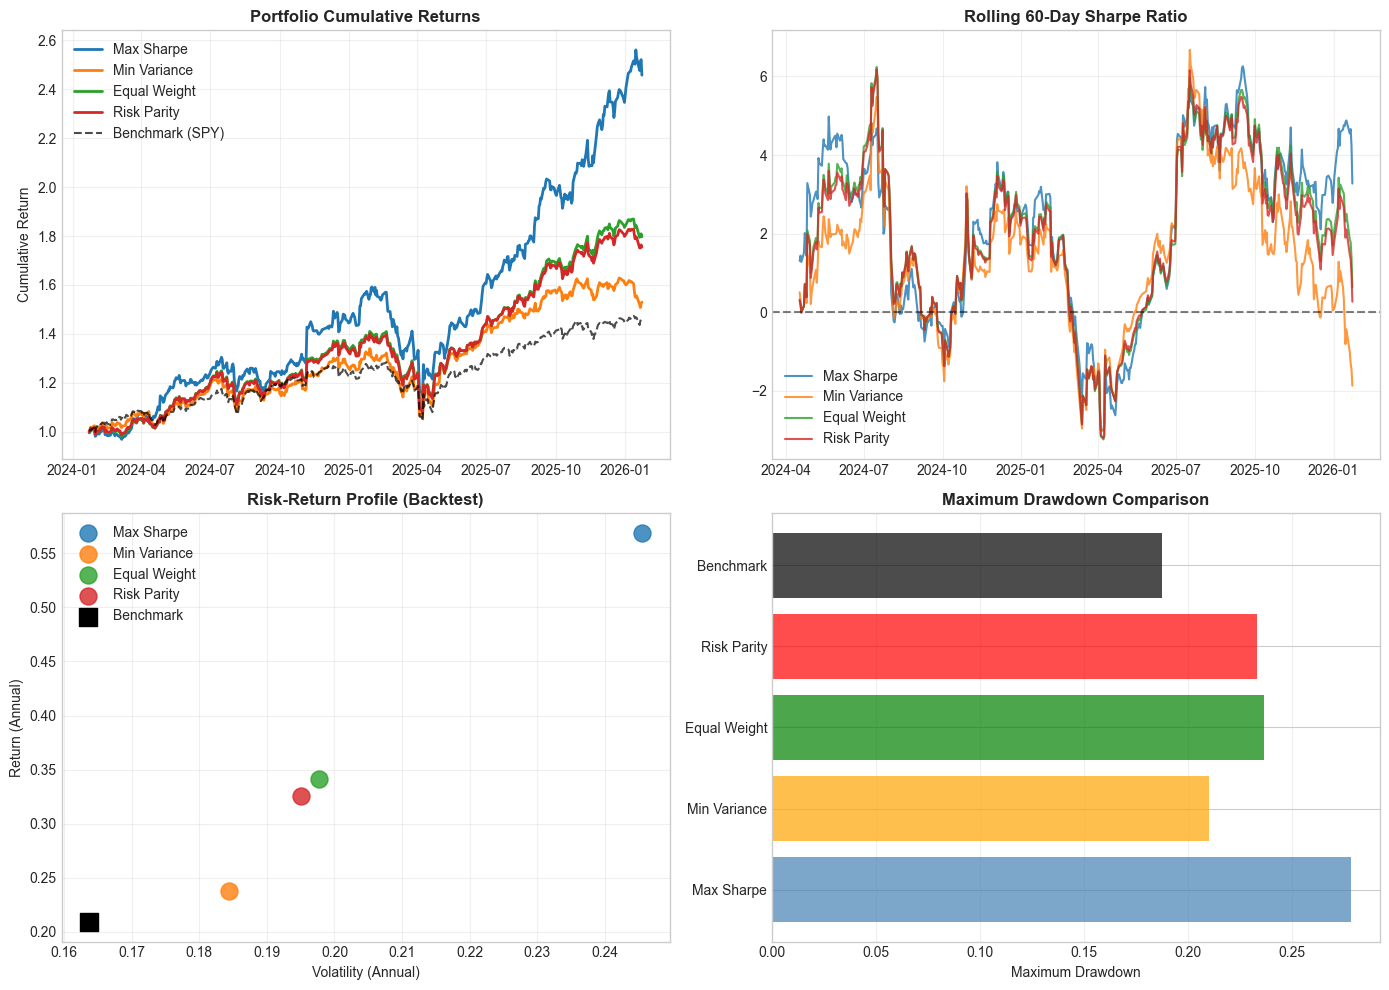

In [9]:
# ============================================================
# CUMULATIVE RETURNS VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cumulative returns comparison
ax1 = axes[0, 0]
for name, result in backtest_results.items():
    ax1.plot(result['cumulative'].index, result['cumulative'].values, label=name, linewidth=2)
ax1.plot(benchmark_result['cumulative'].index, benchmark_result['cumulative'].values, 
         'k--', label='Benchmark (SPY)', linewidth=1.5, alpha=0.7)
ax1.set_title('Portfolio Cumulative Returns', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Sharpe Ratio (60-day)
ax2 = axes[0, 1]
window = 60
for name, result in backtest_results.items():
    rolling_ret = result['returns'].rolling(window).mean() * 252
    rolling_vol = result['returns'].rolling(window).std() * np.sqrt(252)
    rolling_sharpe = (rolling_ret - RISK_FREE_RATE) / rolling_vol
    ax2.plot(rolling_sharpe, label=name, alpha=0.8)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.set_title(f'Rolling {window}-Day Sharpe Ratio', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Risk-Return Scatter
ax3 = axes[1, 0]
for name, result in backtest_results.items():
    ax3.scatter(result['annual_vol'], result['annual_return'], s=150, label=name, alpha=0.8)
ax3.scatter(benchmark_result['annual_vol'], benchmark_result['annual_return'], 
           s=150, marker='s', label='Benchmark', color='black')
ax3.set_xlabel('Volatility (Annual)')
ax3.set_ylabel('Return (Annual)')
ax3.set_title('Risk-Return Profile (Backtest)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Max Drawdown
ax4 = axes[1, 1]
names = list(backtest_results.keys()) + ['Benchmark']
drawdowns = [backtest_results[n]['max_drawdown'] for n in list(backtest_results.keys())] + [benchmark_result['max_drawdown']]
colors = ['steelblue', 'orange', 'green', 'red', 'black']
ax4.barh(names, [-d for d in drawdowns], color=colors[:len(names)], alpha=0.7)
ax4.set_xlabel('Maximum Drawdown')
ax4.set_title('Maximum Drawdown Comparison', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [10]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 5 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Best portfolio
best_sharpe_name = max(backtest_results, key=lambda x: backtest_results[x]['sharpe'])
best_return_name = max(backtest_results, key=lambda x: backtest_results[x]['total_return'])
lowest_risk_name = min(backtest_results, key=lambda x: backtest_results[x]['annual_vol'])

print(f"\n🏆 OPTIMAL PORTFOLIO RECOMMENDATIONS:")
print(f"\n1. 📈 BEST RISK-ADJUSTED (Sharpe): {best_sharpe_name}")
print(f"   Sharpe Ratio: {backtest_results[best_sharpe_name]['sharpe']:.2f}")
print(f"   Weights: {dict(zip(TICKERS, np.round(portfolios[best_sharpe_name], 3)))}")

print(f"\n2. 📊 HIGHEST RETURN: {best_return_name}")
print(f"   Total Return: {backtest_results[best_return_name]['total_return']:.2%}")

print(f"\n3. 🛡️ LOWEST RISK: {lowest_risk_name}")
print(f"   Volatility: {backtest_results[lowest_risk_name]['annual_vol']:.2%}")

# Recommended allocation
print("\n" + "=" * 80)
print("📊 RECOMMENDED ALLOCATION (Maximum Sharpe Portfolio):")
print("=" * 80)
for ticker, weight in zip(TICKERS, max_sharpe_weights):
    if weight > 0.01:
        print(f"   {ticker}: {weight:>8.2%}")

print("\n⚠️ Note: Optimize for Sharpe Ratio balances return with risk!")
print("         Consider your risk tolerance when choosing a portfolio strategy.")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 5 STRATEGY - FINAL RECOMMENDATIONS

🏆 OPTIMAL PORTFOLIO RECOMMENDATIONS:

1. 📈 BEST RISK-ADJUSTED (Sharpe): Max Sharpe
   Sharpe Ratio: 2.11
   Weights: {'AAPL': np.float64(0.0), 'GOOGL': np.float64(0.415), 'MSFT': np.float64(0.0), 'GS': np.float64(0.585), 'JPM': np.float64(0.0)}

2. 📊 HIGHEST RETURN: Max Sharpe
   Total Return: 145.77%

3. 🛡️ LOWEST RISK: Min Variance
   Volatility: 18.44%

📊 RECOMMENDED ALLOCATION (Maximum Sharpe Portfolio):
   GOOGL:   41.48%
   GS:   58.52%

⚠️ Note: Optimize for Sharpe Ratio balances return with risk!
         Consider your risk tolerance when choosing a portfolio strategy.

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-5)

| Week | Concept | Application |
|------|---------|-------------|
| 1 | Returns & Volatility | Portfolio statistics |
| 2 | Statistical Testing | Return distributions |
| 3 | Time Series | Historical data analysis |
| 4 | ML Regression | (Background analysis) |
| **5** | **Modern Portfolio Theory** | **Optimization framework** |
| **5** | **Efficient Frontier** | **Portfolio visualization** |
| **5** | **Mean-Variance** | **Risk-return tradeoff** |
| **5** | **Sharpe Ratio** | **Performance metric** |

---